In [15]:
!pip3 install plotly

In [1]:
!pip3 install catboost

In [27]:
!pip3 install -U kaleido

Requirement already up-to-date: kaleido in c:\users\shaha\anaconda3\lib\site-packages (0.2.1)


In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import plotly.express as px

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 1 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,Directory Traversal,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,NaN,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,Cookie Injection,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,NaN,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,LOG4J,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [2]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",NaN,NaN,NaN,NaN,Directory Traversal,Malware
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN,Cookie Injection,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN,LOG4J,Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=wKm-iDQeCXGjwXGrGJvfzWzs5VYbnWSP75B6BjFz1...,"Mon, 21 Nov 2022 18:39:51 GMT",POST,http://127.0.0.1:5000/cookielogin,,302 FOUND,text/html; charset=utf-8,211,302,<!doctype html>\n<html lang=en>\n<title>Redire...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,/cookielogin,0,username=gASVKgAAAAAAAACMCF9fbWFpbl9flIwGUGVyc...,Cookie Injection,Malware
4278,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=oyXTP1KfNdMwWb_jIYEQYKzE9RZALsuCGCtJtUlju...,"Mon, 21 Nov 2022 18:39:51 GMT",GET,http://127.0.0.1:5000/orders/get/id/7668,,404 NOT FOUND,application/json,36,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign
4279,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=bfYOeMnpxlFA9F7ObPemhCXYmeYNbBteewfAWbnfy...,"Mon, 21 Nov 2022 18:39:52 GMT",POST,http://127.0.0.1:5000/cookielogin,,302 FOUND,text/html; charset=utf-8,211,302,<!doctype html>\n<html lang=en>\n<title>Redire...,username=gASVyAAAAAAAAACMCGJ1aWx0aW5zlIw

In [3]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",None,None,None,None,Directory Traversal,Malware
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,None,None,None,Cookie Injection,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,LOG4J,Malware


In [4]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                'request.headers.Connection',
                'request.headers.Host',
                'request.headers.Accept',
                'request.method',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-Dest',
                'request.headers.Sec-Fetch-User',
                'response.status',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                    'request.headers.Set-Cookie',
                    'request.headers.Date',
                    'request.url',
                    'response.headers.Content-Type',
                    'response.body',
                    'response.headers.Location',
                    'request.headers.Content-Length',
                    'request.headers.Cookie',
                    'response.headers.Set-Cookie'
                    ]

COLUMNS_TO_REMOVE = ['request.body',
                    'response.headers.Content-Length',
                    'request.headers.Date']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=3)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()
    
    

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,0,-0.235702,0,0,0,1,0,0,0,0,0.192450,0,0.000000,0,0.000000,200,0.301511,0.000000,0.0,0.0,0.0,Directory Traversal,Malware
1,0,0.000000,0,0,0,0,0,0,0,0,0.259828,0,-0.894427,4,0.000000,404,0.666667,0.000000,0.0,0.0,0.0,Benign,Benign
2,0,0.577350,0,0,0,0,0,0,0,0,-0.176090,0,0.707107,0,-0.408248,200,-1.000000,-0.316228,0.0,0.0,0.0,Cookie Injection,Malware
3,0,-0.666667,0,0,0,1,0,0,0,0,0.215387,0,0.000000,4,0.000000,404,0.894427,0.000000,0.0,0.0,0.0,Benign,Benign
4,0,0.577350,0,0,0,0,0,0,0,29,0.274721,0,-0.577350,4,0.000000,404,0.666667,0.000000,0.0,0.0,0.0,LOG4J,Malware


In [5]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   request.headers.Host             4282 non-null   int32  
 1   request.headers.User-Agent       4282 non-null   float64
 2   request.headers.Accept-Encoding  4282 non-null   int32  
 3   request.headers.Accept           4282 non-null   int32  
 4   request.headers.Connection       4282 non-null   int32  
 5   request.headers.Accept-Language  4282 non-null   int32  
 6   request.headers.Sec-Fetch-Site   4282 non-null   int32  
 7   request.headers.Sec-Fetch-Mode   4282 non-null   int32  
 8   request.headers.Sec-Fetch-User   4282 non-null   int32  
 9   request.headers.Sec-Fetch-Dest   4282 non-null   int32  
 10  request.headers.Set-Cookie       4282 non-null   float64
 11  request.method                   4282 non-null   int32  
 12  request.url         

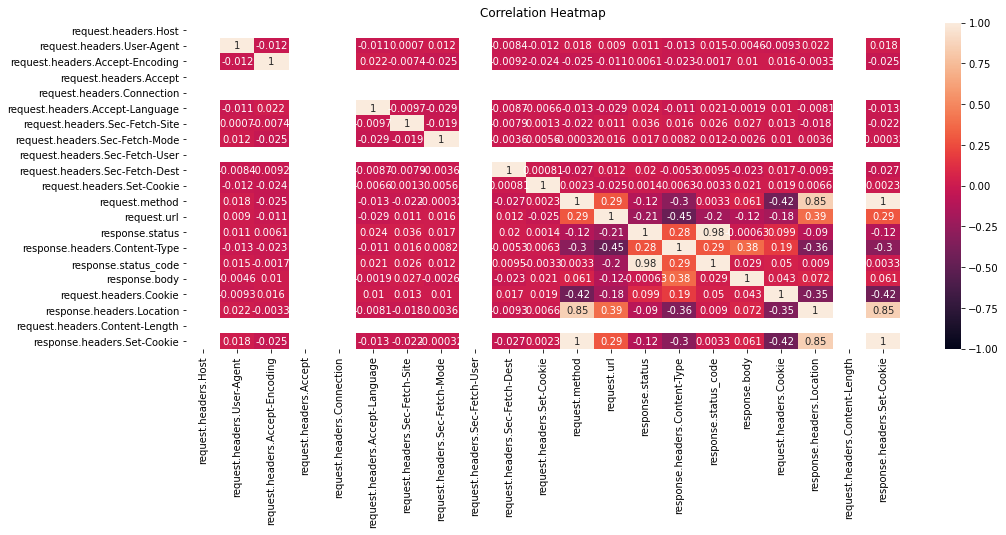

In [6]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

# #remove columns that are with 1 correlation

In [7]:
df.drop('response.headers.Set-Cookie', axis=1, inplace=True)
df.drop('response.status_code', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,attack_type,label
0,0,-0.235702,0,0,0,1,0,0,0,0,0.192450,0,0.000000,0,0.000000,0.301511,0.000000,0.0,0.0,Directory Traversal,Malware
1,0,0.000000,0,0,0,0,0,0,0,0,0.259828,0,-0.894427,4,0.000000,0.666667,0.000000,0.0,0.0,Benign,Benign
2,0,0.577350,0,0,0,0,0,0,0,0,-0.176090,0,0.707107,0,-0.408248,-1.000000,-0.316228,0.0,0.0,Cookie Injection,Malware
3,0,-0.666667,0,0,0,1,0,0,0,0,0.215387,0,0.000000,4,0.000000,0.894427,0.000000,0.0,0.0,Benign,Benign
4,0,0.577350,0,0,0,0,0,0,0,29,0.274721,0,-0.577350,4,0.000000,0.666667,0.000000,0.0,0.0,LOG4J,Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,0,0.000000,0,0,0,2,0,1,0,0,0.000000,1,0.707107,1,-0.408248,0.154303,0.000000,1.0,0.0,Cookie Injection,Malware
4278,0,0.000000,0,0,0,0,0,0,0,0,0.381000,0,0.000000,4,0.000000,-0.447214,0.000000,0.0,0.0,Benign,Benign
4279,0,0.000000,0,0,0,1,0,0,0,0,-0.371391,1,0.707107,1,-0.408248,0.154303,0.000000,1.0,0.0,Cookie Injection,Malware
4280,0,0.000000,0,0,0,1,0,0,0,0,-0.588348,0,-0.447214,4,0.000000,0.666667,0.000000,0.0,0.0,Benign,Benign


## check which fields always have the same value (they have no impact)

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


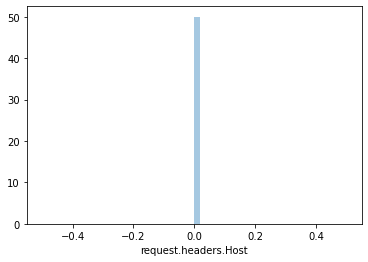

In [8]:
sns.distplot(df['request.headers.Host'])

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


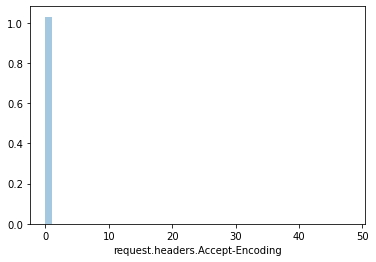

In [9]:
sns.distplot(df['request.headers.Accept-Encoding'])

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


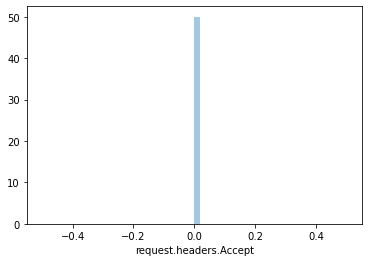

In [10]:
sns.distplot(df['request.headers.Accept'])

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


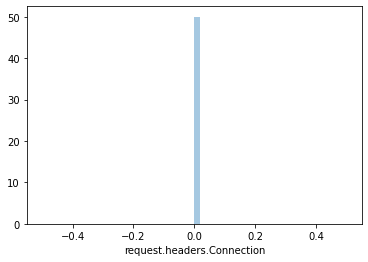

In [11]:
sns.distplot(df['request.headers.Connection'])

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


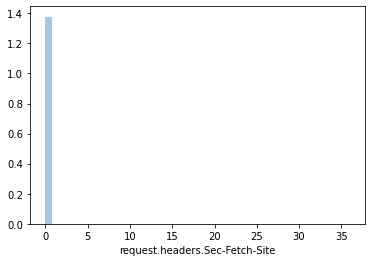

In [12]:
sns.distplot(df['request.headers.Sec-Fetch-Site'])

C:\Users\shaha\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


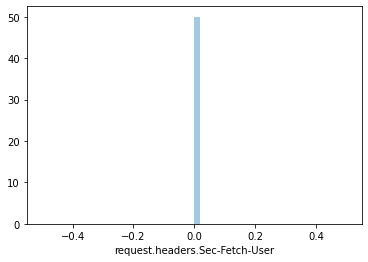

In [13]:
sns.distplot(df['request.headers.Sec-Fetch-User'])

In [14]:
# sns.distplot(df['request.headers.Content-Length'])

In [15]:
def numerize(row):
    if row['label'] == 'Benign':
        return 0
    return 1

df['tag_num'] = df.apply(lambda row: numerize(row), axis=1)
df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,attack_type,label,tag_num
0,0,-0.235702,0,0,0,1,0,0,0,0,0.192450,0,0.000000,0,0.000000,0.301511,0.000000,0.0,0.0,Directory Traversal,Malware,1
1,0,0.000000,0,0,0,0,0,0,0,0,0.259828,0,-0.894427,4,0.000000,0.666667,0.000000,0.0,0.0,Benign,Benign,0
2,0,0.577350,0,0,0,0,0,0,0,0,-0.176090,0,0.707107,0,-0.408248,-1.000000,-0.316228,0.0,0.0,Cookie Injection,Malware,1
3,0,-0.666667,0,0,0,1,0,0,0,0,0.215387,0,0.000000,4,0.000000,0.894427,0.000000,0.0,0.0,Benign,Benign,0
4,0,0.577350,0,0,0,0,0,0,0,29,0.274721,0,-0.577350,4,0.000000,0.666667,0.000000,0.0,0.0,LOG4J,Malware,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,0,0.000000,0,0,0,2,0,1,0,0,0.000000,1,0.707107,1,-0.408248,0.154303,0.000000,1.0,0.0,Cookie Injection,Malware,1
4278,0,0.000000,0,0,0,0,0,0,0,0,0.381000,0,0.000000,4,0.000000,-0.447214,0.000000,0.0,0.0,Benign,Benign,0
4279,0,0.000000,0,0,0,1,0,0,0,0,-0.371391,1,0.707107,1,-0.408248,0.154303,0.000000,1.0,0.0,Cookie Injection,Malware,1
4280,0,0.000000,0,0,0,1,0,0,0,0,-0.588348,0,-0.447214,4,0.000000,0.666667,0.000000,0.0,0.0,Benign,Benign,0


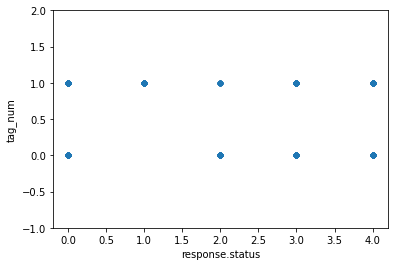

In [16]:
#Relationship with numerical variables
var = 'response.status'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); # do not `assume here any thing this is just examples

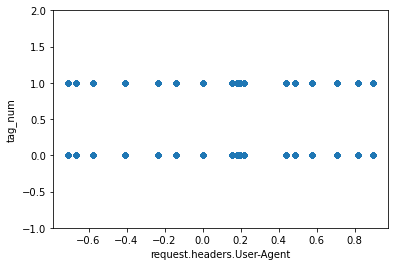

In [17]:
#Relationship with numerical variables
var = 'request.headers.User-Agent'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); # do not `assume here any thing this is just examples

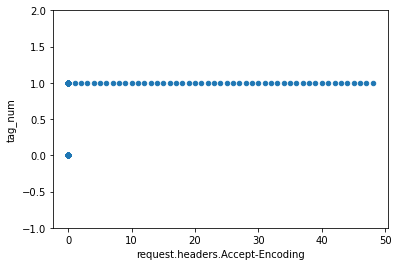

In [18]:
#Relationship with numerical variables
var = 'request.headers.Accept-Encoding'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); # do not `assume here any thing this is just examples

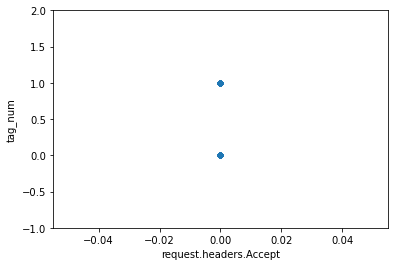

In [19]:
#Relationship with numerical variables
var = 'request.headers.Accept'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); # do not `assume here any thing this is just examples

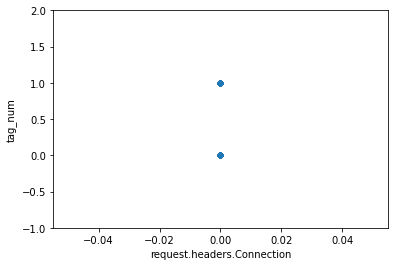

In [20]:
#Relationship with numerical variables
var = 'request.headers.Connection'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); # do not `assume here any thing this is just examples

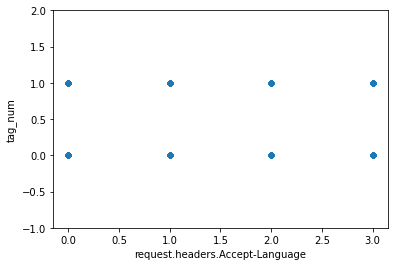

In [21]:
#Relationship with numerical variables
var = 'request.headers.Accept-Language'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); # do not `assume here any thing this is just examples

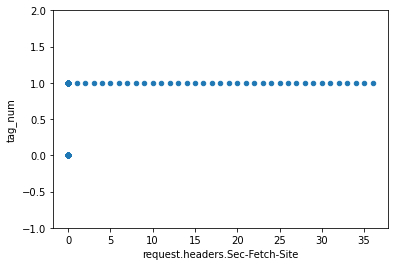

In [22]:
#Relationship with numerical variables
var = 'request.headers.Sec-Fetch-Site'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); 

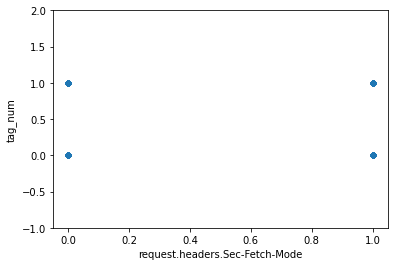

In [23]:
#Relationship with numerical variables
var = 'request.headers.Sec-Fetch-Mode'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); 

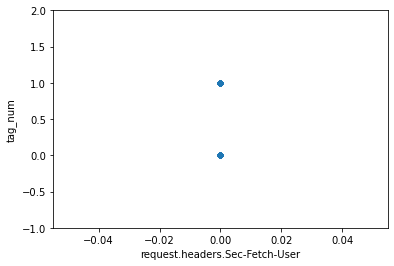

In [24]:
#Relationship with numerical variables
var = 'request.headers.Sec-Fetch-User'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); 

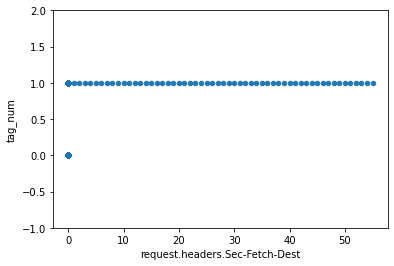

In [25]:
#Relationship with numerical variables
var = 'request.headers.Sec-Fetch-Dest'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); 

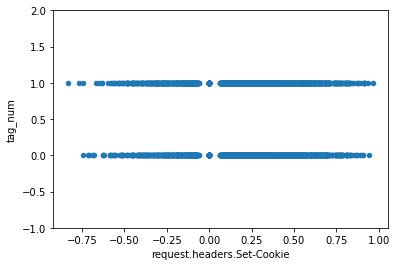

In [26]:
#Relationship with numerical variables
var = 'request.headers.Set-Cookie'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); 

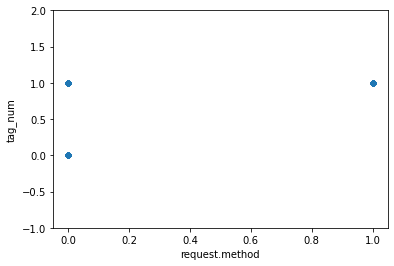

In [27]:
#Relationship with numerical variables
var = 'request.method'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); 

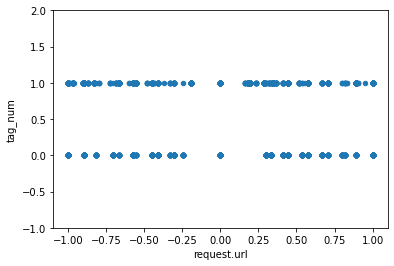

In [28]:
#Relationship with numerical variables
var = 'request.url'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); 

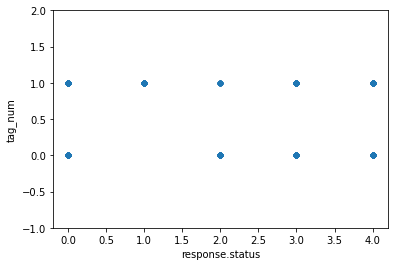

In [29]:
#Relationship with numerical variables
var = 'response.status'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); 

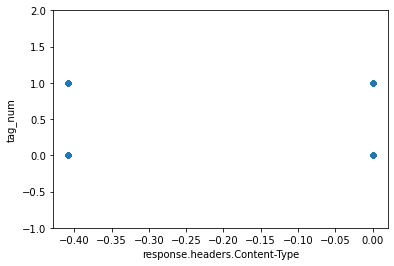

In [30]:
#Relationship with numerical variables
var = 'response.headers.Content-Type'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); 

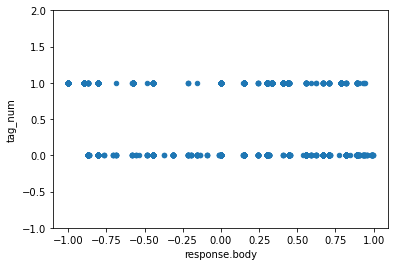

In [31]:
#Relationship with numerical variables
var = 'response.body'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); 

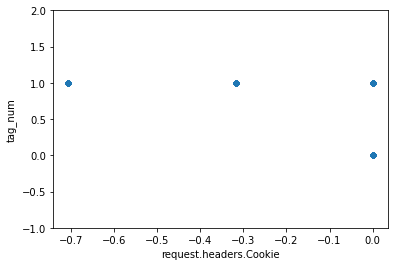

In [32]:
#Relationship with numerical variables
var = 'request.headers.Cookie'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2)); 

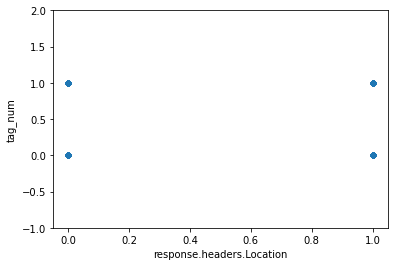

In [33]:
#Relationship with numerical variables
var = 'response.headers.Location'
data = pd.concat([df['tag_num'], df[var]], axis=1)
data.plot.scatter(x=var, y='tag_num', ylim=(-1,2));

## drop fields that have no impact

In [34]:
df.drop('request.headers.Host', axis=1, inplace=True)
df.drop('request.headers.Content-Length', axis=1, inplace=True)

df

,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.body,request.headers.Cookie,response.headers.Location,attack_type,label,tag_num
0,-0.235702,0,0,0,1,0,0,0,0,0.192450,0,0.000000,0,0.000000,0.301511,0.000000,0.0,Directory Traversal,Malware,1
1,0.000000,0,0,0,0,0,0,0,0,0.259828,0,-0.894427,4,0.000000,0.666667,0.000000,0.0,Benign,Benign,0
2,0.577350,0,0,0,0,0,0,0,0,-0.176090,0,0.707107,0,-0.408248,-1.000000,-0.316228,0.0,Cookie Injection,Malware,1
3,-0.666667,0,0,0,1,0,0,0,0,0.215387,0,0.000000,4,0.000000,0.894427,0.000000,0.0,Benign,Benign,0
4,0.577350,0,0,0,0,0,0,0,29,0.274721,0,-0.577350,4,0.000000,0.666667,0.000000,0.0,LOG4J,Malware,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,0.000000,0,0,0,2,0,1,0,0,0.000000,1,0.707107,1,-0.408248,0.154303,0.000000,1.0,Cookie Injection,Malware,1
4278,0.000000,0,0,0,0,0,0,0,0,0.381000,0,0.000000,4,0.000000,-0.447214,0.000000,0.0,Benign,Benign,0
4279,0.000000,0,0,0,1,0,0,0,0,-0.371391,1,0.707107,1,-0.408248,0.154303,0.000000,1.0,Cookie Injection,Malware,1
4280,0.000000,0,0,0,1,0,0,0,0,-0.588348,0,-0.447214,4,0.000000,0.666667,0.000000,0.0,Benign,Benign,0


In [35]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
features_list.remove('tag_num')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept', 'request.headers.Connection', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-User', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Type', 'response.body', 'request.headers.Cookie', 'response.headers.Location']


request.headers.User-Agent         float64
request.headers.Accept-Encoding      int32
request.headers.Accept               int32
request.headers.Connection           int32
request.headers.Accept-Language      int32
request.headers.Sec-Fetch-Site       int32
request.headers.Sec-Fetch-Mode       int32
request.headers.Sec-Fetch-User       int32
request.headers.Sec-Fetch-Dest       int32
request.headers.Set-Cookie         float64
request.method                       int32
request.url                        float64
response.status                      int32
response.headers.Content-Type      float64
response.body                      float64
request.headers.Cookie             float64
response.headers.Location          float64
attack_type                         object
label                               object
tag_num                              int64
dtype: object

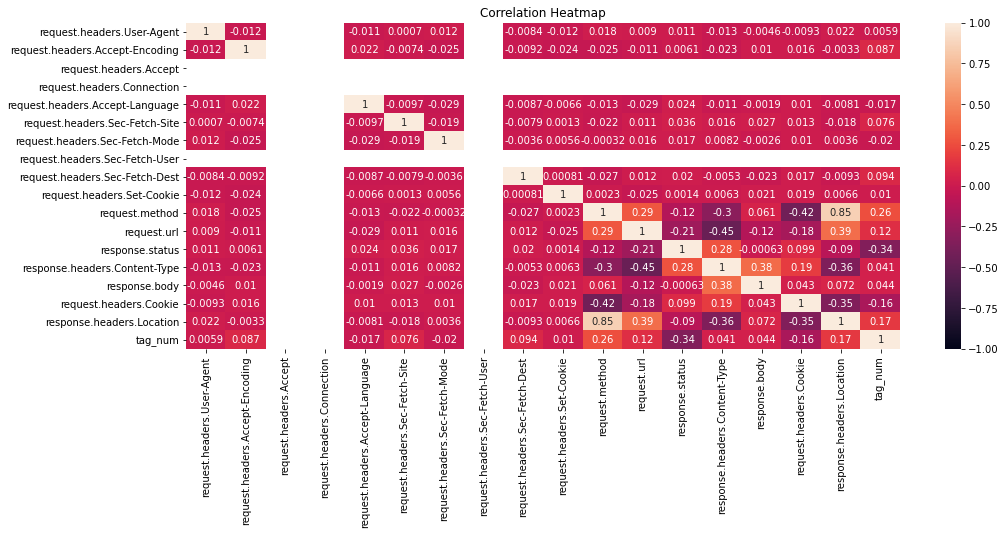

In [36]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

## Train test split¶

In [37]:
df = df.sample(frac=1)

In [38]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(3526, 17) (3526,)
(756, 17) (756,)


Counter({'Malware': 2264, 'Benign': 2018})

## Model choosing and fitting 

### Random Forest

In [39]:
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=50)

# Train Model
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


## Result printout 

              precision    recall  f1-score   support

      Benign    0.90000   0.93539   0.91736       356
     Malware    0.94041   0.90750   0.92366       400

    accuracy                        0.92063       756
   macro avg    0.92021   0.92145   0.92051       756
weighted avg    0.92138   0.92063   0.92069       756



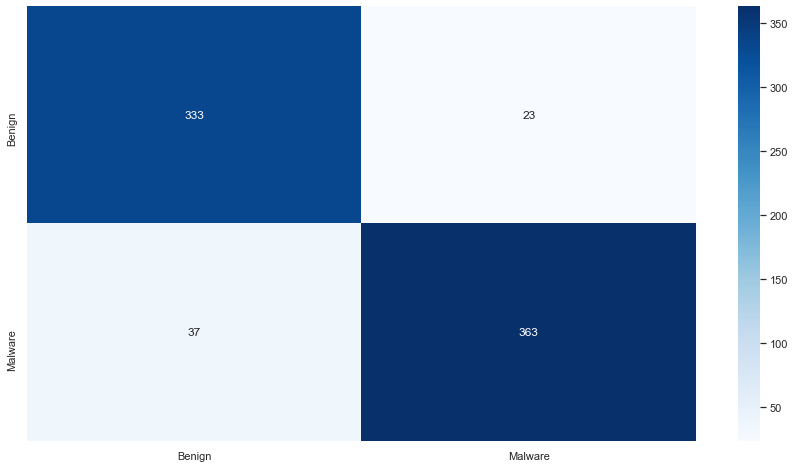

In [40]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

## CatBoost

In [47]:
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier

# Encode labels
le = LabelEncoder()
le.fit(y_train)
y_encoded = le.transform(y_train)

# Create CatBoost model
cat = CatBoostClassifier(early_stopping_rounds=1, max_depth=5)

# Fit model to data
cat.fit(X_train, y_encoded)

# Check data balance and variety
print(sorted(Counter(y_train).items()))

Learning rate set to 0.017645
0:	learn: 0.6781098	total: 5.3ms	remaining: 5.3s
1:	learn: 0.6679213	total: 7.62ms	remaining: 3.8s
2:	learn: 0.6587977	total: 10ms	remaining: 3.32s
3:	learn: 0.6489162	total: 12.3ms	remaining: 3.07s
4:	learn: 0.6355818	total: 14.8ms	remaining: 2.95s
5:	learn: 0.6240744	total: 17.5ms	remaining: 2.9s
6:	learn: 0.6132296	total: 21.4ms	remaining: 3.04s
7:	learn: 0.6018125	total: 24ms	remaining: 2.97s
8:	learn: 0.5946608	total: 26.5ms	remaining: 2.92s
9:	learn: 0.5839166	total: 29.4ms	remaining: 2.91s
10:	learn: 0.5724668	total: 32.4ms	remaining: 2.91s
11:	learn: 0.5665560	total: 35.8ms	remaining: 2.95s
12:	learn: 0.5577673	total: 38.6ms	remaining: 2.93s
13:	learn: 0.5494935	total: 41.4ms	remaining: 2.92s
14:	learn: 0.5423320	total: 44.2ms	remaining: 2.9s
15:	learn: 0.5366924	total: 47.1ms	remaining: 2.9s
16:	learn: 0.5305790	total: 50ms	remaining: 2.89s
17:	learn: 0.5245693	total: 53.3ms	remaining: 2.9s
18:	learn: 0.5153411	total: 56ms	remaining: 2.89s
19:	lea

195:	learn: 0.2406382	total: 496ms	remaining: 2.04s
196:	learn: 0.2402307	total: 499ms	remaining: 2.03s
197:	learn: 0.2399649	total: 501ms	remaining: 2.03s
198:	learn: 0.2398419	total: 503ms	remaining: 2.02s
199:	learn: 0.2397163	total: 506ms	remaining: 2.02s
200:	learn: 0.2394214	total: 508ms	remaining: 2.02s
201:	learn: 0.2391591	total: 511ms	remaining: 2.02s
202:	learn: 0.2384516	total: 513ms	remaining: 2.02s
203:	learn: 0.2377519	total: 515ms	remaining: 2.01s
204:	learn: 0.2373329	total: 518ms	remaining: 2.01s
205:	learn: 0.2368079	total: 520ms	remaining: 2s
206:	learn: 0.2363423	total: 522ms	remaining: 2s
207:	learn: 0.2358726	total: 525ms	remaining: 2s
208:	learn: 0.2355924	total: 527ms	remaining: 1.99s
209:	learn: 0.2353001	total: 529ms	remaining: 1.99s
210:	learn: 0.2351203	total: 532ms	remaining: 1.99s
211:	learn: 0.2345717	total: 534ms	remaining: 1.99s
212:	learn: 0.2344429	total: 537ms	remaining: 1.99s
213:	learn: 0.2339654	total: 539ms	remaining: 1.98s
214:	learn: 0.2336369

411:	learn: 0.1958734	total: 1s	remaining: 1.43s
412:	learn: 0.1957715	total: 1s	remaining: 1.42s
413:	learn: 0.1957209	total: 1s	remaining: 1.42s
414:	learn: 0.1956808	total: 1.01s	remaining: 1.42s
415:	learn: 0.1955674	total: 1.01s	remaining: 1.42s
416:	learn: 0.1955025	total: 1.01s	remaining: 1.41s
417:	learn: 0.1953721	total: 1.01s	remaining: 1.41s
418:	learn: 0.1951666	total: 1.02s	remaining: 1.41s
419:	learn: 0.1949911	total: 1.02s	remaining: 1.41s
420:	learn: 0.1948106	total: 1.02s	remaining: 1.4s
421:	learn: 0.1947772	total: 1.02s	remaining: 1.4s
422:	learn: 0.1946596	total: 1.02s	remaining: 1.4s
423:	learn: 0.1945568	total: 1.03s	remaining: 1.4s
424:	learn: 0.1942981	total: 1.03s	remaining: 1.39s
425:	learn: 0.1940390	total: 1.03s	remaining: 1.39s
426:	learn: 0.1939176	total: 1.03s	remaining: 1.39s
427:	learn: 0.1935071	total: 1.04s	remaining: 1.39s
428:	learn: 0.1934261	total: 1.04s	remaining: 1.38s
429:	learn: 0.1933165	total: 1.04s	remaining: 1.38s
430:	learn: 0.1930867	tot

628:	learn: 0.1726848	total: 1.5s	remaining: 888ms
629:	learn: 0.1726288	total: 1.51s	remaining: 886ms
630:	learn: 0.1725745	total: 1.51s	remaining: 883ms
631:	learn: 0.1725392	total: 1.51s	remaining: 880ms
632:	learn: 0.1725024	total: 1.51s	remaining: 878ms
633:	learn: 0.1724382	total: 1.52s	remaining: 875ms
634:	learn: 0.1723516	total: 1.52s	remaining: 873ms
635:	learn: 0.1721811	total: 1.52s	remaining: 870ms
636:	learn: 0.1720686	total: 1.52s	remaining: 868ms
637:	learn: 0.1720067	total: 1.52s	remaining: 865ms
638:	learn: 0.1718429	total: 1.53s	remaining: 863ms
639:	learn: 0.1717693	total: 1.53s	remaining: 860ms
640:	learn: 0.1717397	total: 1.53s	remaining: 858ms
641:	learn: 0.1717184	total: 1.53s	remaining: 855ms
642:	learn: 0.1716224	total: 1.53s	remaining: 853ms
643:	learn: 0.1715306	total: 1.54s	remaining: 850ms
644:	learn: 0.1714724	total: 1.54s	remaining: 848ms
645:	learn: 0.1713627	total: 1.54s	remaining: 845ms
646:	learn: 0.1713193	total: 1.54s	remaining: 843ms
647:	learn: 0

853:	learn: 0.1567552	total: 2.01s	remaining: 344ms
854:	learn: 0.1567306	total: 2.02s	remaining: 342ms
855:	learn: 0.1566921	total: 2.02s	remaining: 340ms
856:	learn: 0.1566508	total: 2.02s	remaining: 337ms
857:	learn: 0.1565814	total: 2.02s	remaining: 335ms
858:	learn: 0.1564595	total: 2.02s	remaining: 332ms
859:	learn: 0.1563793	total: 2.03s	remaining: 330ms
860:	learn: 0.1563266	total: 2.03s	remaining: 328ms
861:	learn: 0.1562741	total: 2.03s	remaining: 325ms
862:	learn: 0.1562596	total: 2.03s	remaining: 323ms
863:	learn: 0.1562261	total: 2.04s	remaining: 321ms
864:	learn: 0.1562052	total: 2.04s	remaining: 318ms
865:	learn: 0.1559975	total: 2.04s	remaining: 316ms
866:	learn: 0.1558194	total: 2.04s	remaining: 313ms
867:	learn: 0.1556216	total: 2.04s	remaining: 311ms
868:	learn: 0.1556003	total: 2.05s	remaining: 308ms
869:	learn: 0.1555470	total: 2.05s	remaining: 306ms
870:	learn: 0.1555103	total: 2.05s	remaining: 304ms
871:	learn: 0.1554678	total: 2.05s	remaining: 301ms
872:	learn: 

              precision    recall  f1-score   support

      Benign    0.92287   0.94101   0.93185       356
     Malware    0.94656   0.93000   0.93821       400

    accuracy                        0.93519       756
   macro avg    0.93471   0.93551   0.93503       756
weighted avg    0.93540   0.93519   0.93521       756



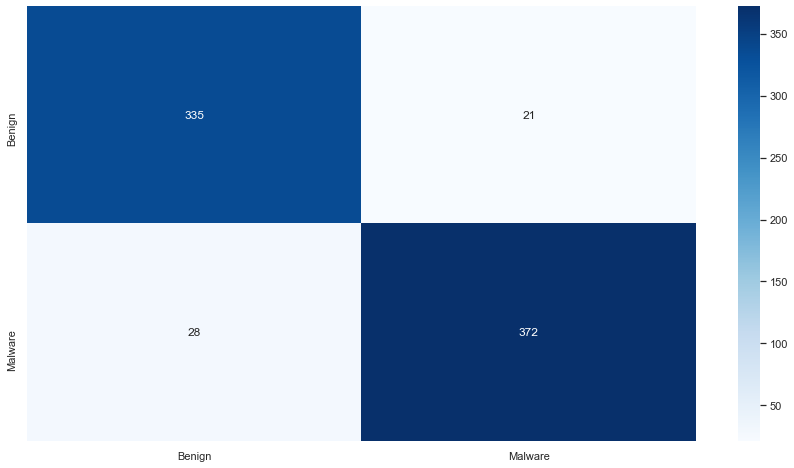

In [48]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = cat.predict(X_test)
true_labels = y_test
# Decode predictions
predictions_decoded = le.inverse_transform(predictions)
cf_matrix = confusion_matrix(true_labels, predictions_decoded)
clf_report = classification_report(true_labels, predictions_decoded, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

### Naive Bayes

In [114]:
from sklearn.naive_bayes import GaussianNB
logisticRegr = GaussianNB()
logisticRegr.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.54021   1.00000   0.70148       356
     Malware    1.00000   0.24250   0.39034       400

    accuracy                        0.59921       756
   macro avg    0.77011   0.62125   0.54591       756
weighted avg    0.78349   0.59921   0.53686       756



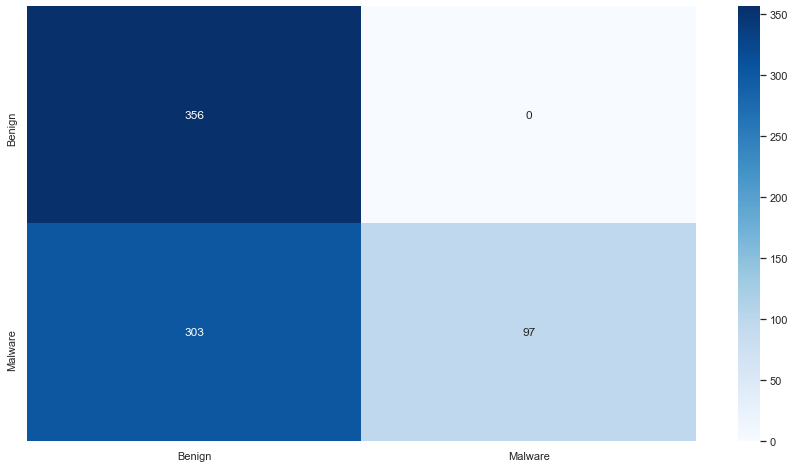

In [115]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = logisticRegr.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

# SVM- try

In [116]:
from sklearn import svm

logisticRegr = svm.SVC(kernel='linear', C=0.9)
logisticRegr.fit(X_train, y_train)
# # Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.65689   0.62921   0.64275       356
     Malware    0.68193   0.70750   0.69448       400

    accuracy                        0.67063       756
   macro avg    0.66941   0.66836   0.66862       756
weighted avg    0.67014   0.67063   0.67012       756



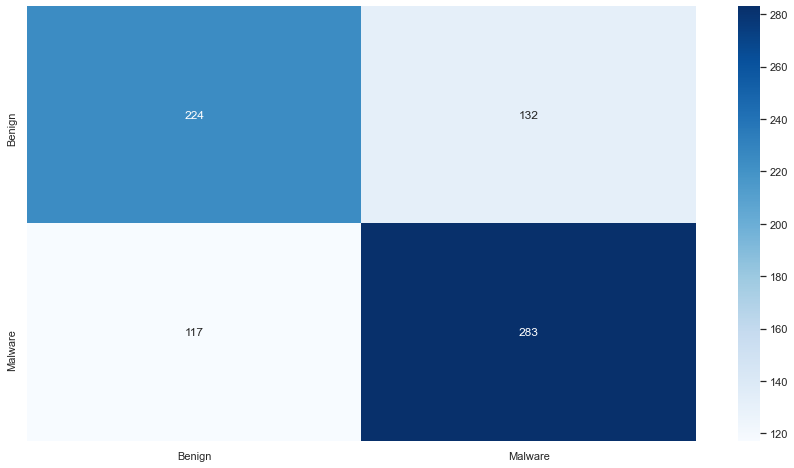

In [117]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = logisticRegr.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### Dummy

In [118]:
from sklearn.dummy import DummyClassifier

dum = DummyClassifier(strategy='stratified')
dum.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.46045   0.45787   0.45915       356
     Malware    0.51990   0.52250   0.52120       400

    accuracy                        0.49206       756
   macro avg    0.49018   0.49018   0.49018       756
weighted avg    0.49191   0.49206   0.49198       756



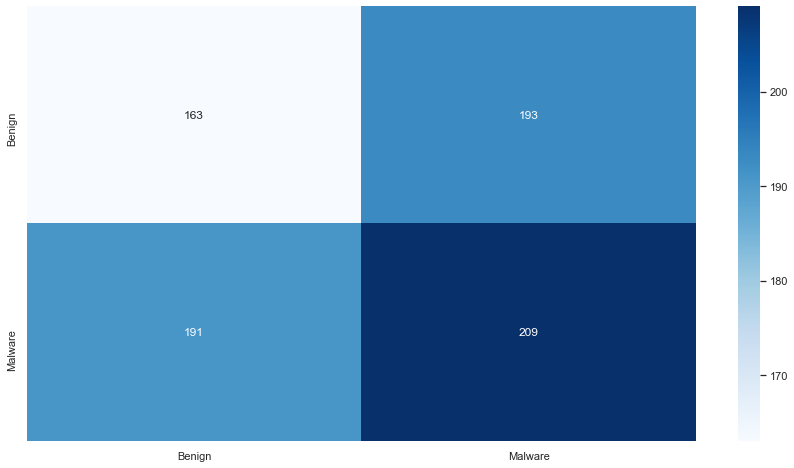

In [119]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = dum.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### KNN

In [120]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.91176   0.78371   0.84290       356
     Malware    0.82889   0.93250   0.87765       400

    accuracy                        0.86243       756
   macro avg    0.87033   0.85810   0.86027       756
weighted avg    0.86792   0.86243   0.86128       756



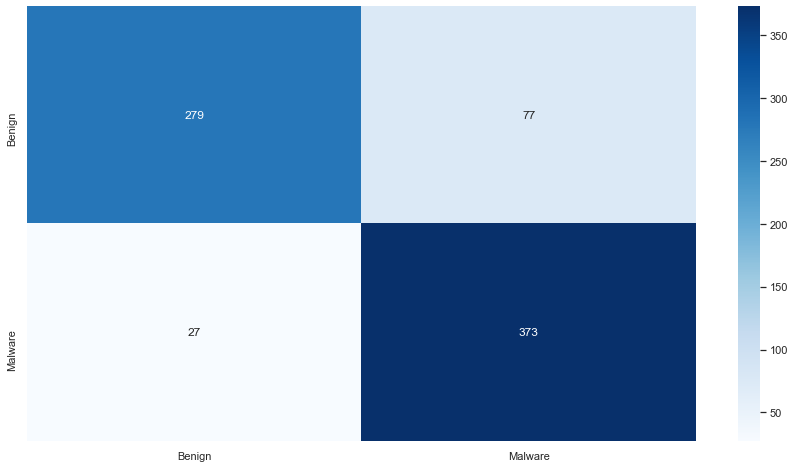

In [121]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = knn.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### Ridge

In [122]:
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier(alpha=0.5).fit(X_train, y_train)
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.68564   0.77809   0.72895       356
     Malware    0.77557   0.68250   0.72606       400

    accuracy                        0.72751       756
   macro avg    0.73061   0.73029   0.72751       756
weighted avg    0.73322   0.72751   0.72742       756



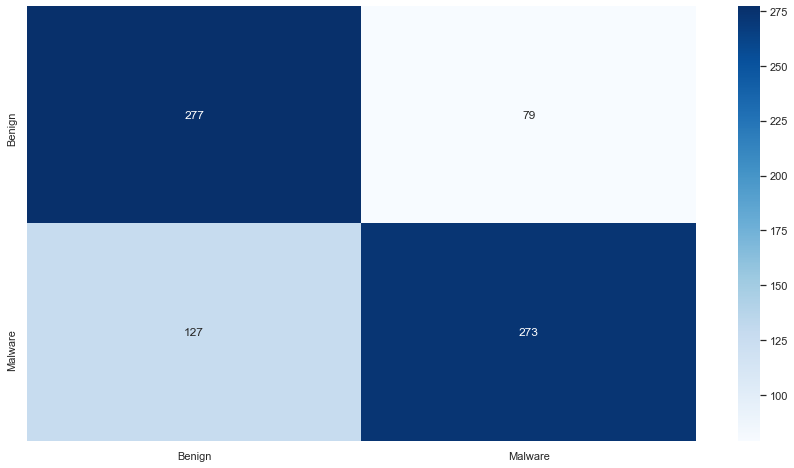

In [123]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = ridge.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### SVM SVC

In [124]:
svc = svm.SVC(gamma = 'auto')
svc.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.93266   0.77809   0.84839       356
     Malware    0.82789   0.95000   0.88475       400

    accuracy                        0.86905       756
   macro avg    0.88027   0.86404   0.86657       756
weighted avg    0.87722   0.86905   0.86763       756



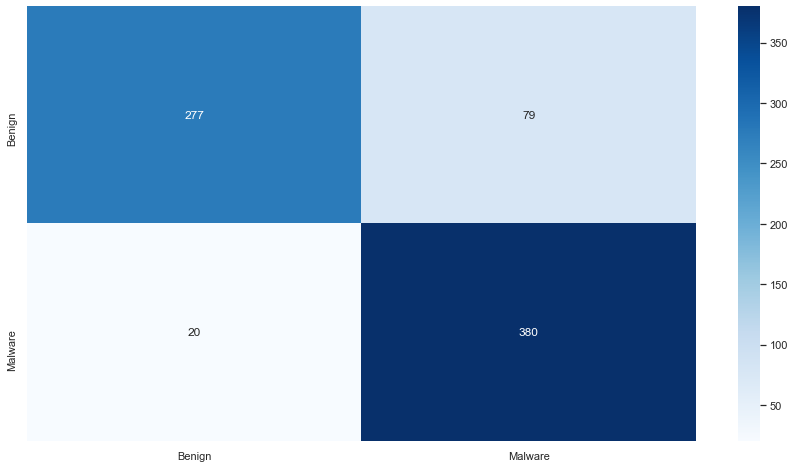

In [125]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = svc.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### Ada boost

In [870]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=600)
ada.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.89908   0.82584   0.86091       356
     Malware    0.85548   0.91750   0.88540       400

    accuracy                        0.87434       756
   macro avg    0.87728   0.87167   0.87316       756
weighted avg    0.87601   0.87434   0.87387       756



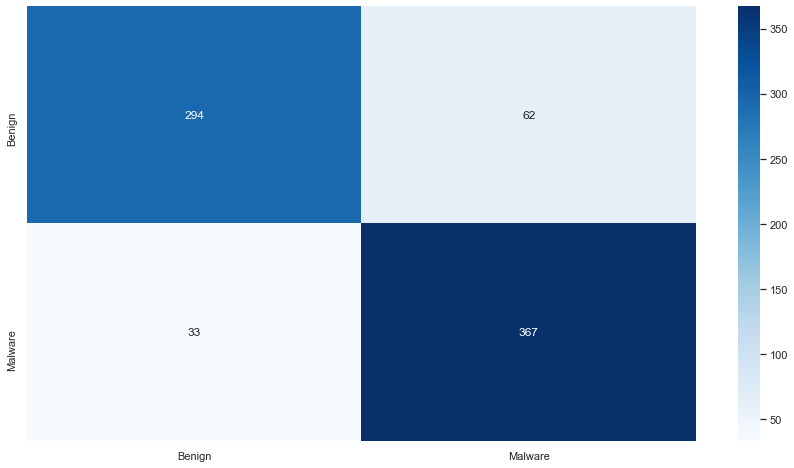

In [871]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = ada.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### Stacking

In [63]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators = [('Random forest', clf), ('Cat Boost', cat)],
                           n_jobs = -1) 

# Encode labels
le = LabelEncoder()
le.fit(y_train)
y_encoded = le.transform(y_train)
stack.fit(X_train, y_encoded)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.93820   0.93820   0.93820       356
     Malware    0.94500   0.94500   0.94500       400

    accuracy                        0.94180       756
   macro avg    0.94160   0.94160   0.94160       756
weighted avg    0.94180   0.94180   0.94180       756



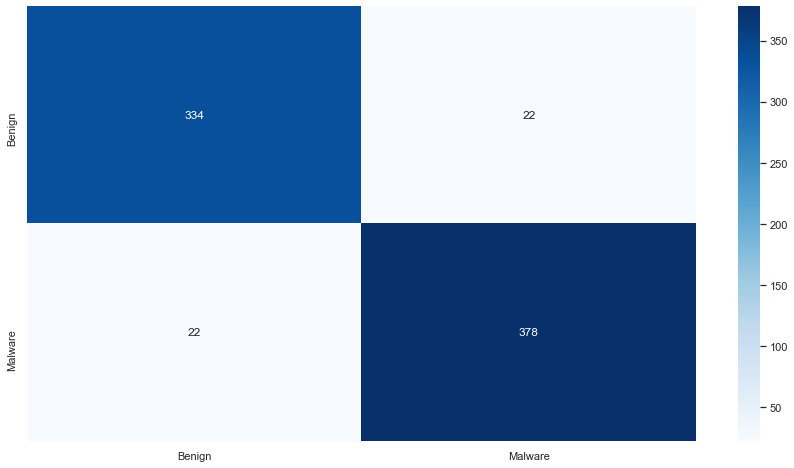

In [64]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = stack.predict(X_test)
true_labels = y_test
# Decode predictions
predictions_decoded = le.inverse_transform(predictions)
lc_matrix = confusion_matrix(true_labels, predictions_decoded)
lc_report = classification_report(true_labels, predictions_decoded, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## hard voting

In [67]:
from sklearn.ensemble import VotingClassifier

vot = VotingClassifier(estimators = [('Cat Boost', cat), ('Random forest', clf), ('Ada Boost', ada)], voting='hard')
# Encode labels
le = LabelEncoder()
le.fit(y_train)
y_encoded = le.transform(y_train)
vot.fit(X_train, y_encoded)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

Learning rate set to 0.017645
0:	learn: 0.6754752	total: 2.95ms	remaining: 2.95s
1:	learn: 0.6610210	total: 5.73ms	remaining: 2.86s
2:	learn: 0.6462245	total: 9.45ms	remaining: 3.14s
3:	learn: 0.6300297	total: 12.1ms	remaining: 3.01s
4:	learn: 0.6188870	total: 14.9ms	remaining: 2.96s
5:	learn: 0.6086438	total: 17.8ms	remaining: 2.95s
6:	learn: 0.5964490	total: 21.1ms	remaining: 2.99s
7:	learn: 0.5884870	total: 24.7ms	remaining: 3.06s
8:	learn: 0.5791752	total: 27.9ms	remaining: 3.07s
9:	learn: 0.5677163	total: 31.5ms	remaining: 3.12s
10:	learn: 0.5531903	total: 34.9ms	remaining: 3.13s
11:	learn: 0.5465547	total: 38.1ms	remaining: 3.13s
12:	learn: 0.5384314	total: 41.2ms	remaining: 3.13s
13:	learn: 0.5309830	total: 44.1ms	remaining: 3.11s
14:	learn: 0.5244026	total: 46.8ms	remaining: 3.07s
15:	learn: 0.5174940	total: 49.8ms	remaining: 3.06s
16:	learn: 0.5095938	total: 52.8ms	remaining: 3.05s
17:	learn: 0.5030626	total: 55.5ms	remaining: 3.03s
18:	learn: 0.4946905	total: 58.4ms	remaining

184:	learn: 0.2322724	total: 502ms	remaining: 2.21s
185:	learn: 0.2314033	total: 504ms	remaining: 2.21s
186:	learn: 0.2311464	total: 507ms	remaining: 2.2s
187:	learn: 0.2309826	total: 509ms	remaining: 2.2s
188:	learn: 0.2303810	total: 511ms	remaining: 2.19s
189:	learn: 0.2300729	total: 514ms	remaining: 2.19s
190:	learn: 0.2296250	total: 517ms	remaining: 2.19s
191:	learn: 0.2294670	total: 519ms	remaining: 2.19s
192:	learn: 0.2293163	total: 522ms	remaining: 2.18s
193:	learn: 0.2286654	total: 526ms	remaining: 2.19s
194:	learn: 0.2284814	total: 529ms	remaining: 2.18s
195:	learn: 0.2277447	total: 531ms	remaining: 2.18s
196:	learn: 0.2274806	total: 534ms	remaining: 2.17s
197:	learn: 0.2271900	total: 536ms	remaining: 2.17s
198:	learn: 0.2268854	total: 538ms	remaining: 2.17s
199:	learn: 0.2267375	total: 541ms	remaining: 2.16s
200:	learn: 0.2266664	total: 543ms	remaining: 2.16s
201:	learn: 0.2262248	total: 546ms	remaining: 2.15s
202:	learn: 0.2256222	total: 548ms	remaining: 2.15s
203:	learn: 0.

371:	learn: 0.1941494	total: 1s	remaining: 1.7s
372:	learn: 0.1941163	total: 1.01s	remaining: 1.69s
373:	learn: 0.1940513	total: 1.01s	remaining: 1.69s
374:	learn: 0.1939848	total: 1.01s	remaining: 1.69s
375:	learn: 0.1939147	total: 1.01s	remaining: 1.68s
376:	learn: 0.1937898	total: 1.02s	remaining: 1.68s
377:	learn: 0.1937719	total: 1.02s	remaining: 1.68s
378:	learn: 0.1936418	total: 1.02s	remaining: 1.67s
379:	learn: 0.1934338	total: 1.02s	remaining: 1.67s
380:	learn: 0.1932253	total: 1.03s	remaining: 1.67s
381:	learn: 0.1931482	total: 1.03s	remaining: 1.67s
382:	learn: 0.1929367	total: 1.03s	remaining: 1.66s
383:	learn: 0.1928559	total: 1.03s	remaining: 1.66s
384:	learn: 0.1927411	total: 1.04s	remaining: 1.66s
385:	learn: 0.1926538	total: 1.04s	remaining: 1.66s
386:	learn: 0.1925739	total: 1.04s	remaining: 1.65s
387:	learn: 0.1925188	total: 1.04s	remaining: 1.65s
388:	learn: 0.1923585	total: 1.05s	remaining: 1.65s
389:	learn: 0.1921270	total: 1.05s	remaining: 1.64s
390:	learn: 0.19

565:	learn: 0.1717057	total: 1.51s	remaining: 1.16s
566:	learn: 0.1716392	total: 1.51s	remaining: 1.16s
567:	learn: 0.1715249	total: 1.52s	remaining: 1.15s
568:	learn: 0.1714232	total: 1.52s	remaining: 1.15s
569:	learn: 0.1713208	total: 1.52s	remaining: 1.15s
570:	learn: 0.1712760	total: 1.52s	remaining: 1.15s
571:	learn: 0.1712103	total: 1.53s	remaining: 1.14s
572:	learn: 0.1710995	total: 1.53s	remaining: 1.14s
573:	learn: 0.1710502	total: 1.53s	remaining: 1.14s
574:	learn: 0.1709780	total: 1.53s	remaining: 1.13s
575:	learn: 0.1708888	total: 1.53s	remaining: 1.13s
576:	learn: 0.1708332	total: 1.54s	remaining: 1.13s
577:	learn: 0.1707079	total: 1.54s	remaining: 1.12s
578:	learn: 0.1706627	total: 1.54s	remaining: 1.12s
579:	learn: 0.1705501	total: 1.54s	remaining: 1.12s
580:	learn: 0.1704907	total: 1.55s	remaining: 1.11s
581:	learn: 0.1703974	total: 1.55s	remaining: 1.11s
582:	learn: 0.1702986	total: 1.55s	remaining: 1.11s
583:	learn: 0.1701054	total: 1.55s	remaining: 1.11s
584:	learn: 

765:	learn: 0.1544793	total: 2.02s	remaining: 617ms
766:	learn: 0.1543826	total: 2.02s	remaining: 615ms
767:	learn: 0.1543334	total: 2.02s	remaining: 612ms
768:	learn: 0.1542355	total: 2.03s	remaining: 609ms
769:	learn: 0.1541036	total: 2.03s	remaining: 606ms
770:	learn: 0.1540305	total: 2.03s	remaining: 604ms
771:	learn: 0.1539243	total: 2.03s	remaining: 601ms
772:	learn: 0.1538968	total: 2.04s	remaining: 598ms
773:	learn: 0.1538242	total: 2.04s	remaining: 595ms
774:	learn: 0.1537553	total: 2.04s	remaining: 593ms
775:	learn: 0.1536799	total: 2.04s	remaining: 590ms
776:	learn: 0.1536548	total: 2.04s	remaining: 587ms
777:	learn: 0.1535585	total: 2.05s	remaining: 584ms
778:	learn: 0.1534732	total: 2.05s	remaining: 582ms
779:	learn: 0.1534492	total: 2.05s	remaining: 579ms
780:	learn: 0.1533064	total: 2.06s	remaining: 576ms
781:	learn: 0.1532746	total: 2.06s	remaining: 574ms
782:	learn: 0.1532010	total: 2.06s	remaining: 571ms
783:	learn: 0.1531029	total: 2.06s	remaining: 568ms
784:	learn: 

962:	learn: 0.1415273	total: 2.53s	remaining: 97.3ms
963:	learn: 0.1413580	total: 2.53s	remaining: 94.6ms
964:	learn: 0.1412500	total: 2.54s	remaining: 92ms
965:	learn: 0.1411349	total: 2.54s	remaining: 89.3ms
966:	learn: 0.1410143	total: 2.54s	remaining: 86.7ms
967:	learn: 0.1409098	total: 2.54s	remaining: 84.1ms
968:	learn: 0.1408292	total: 2.55s	remaining: 81.5ms
969:	learn: 0.1407234	total: 2.55s	remaining: 78.8ms
970:	learn: 0.1406776	total: 2.55s	remaining: 76.2ms
971:	learn: 0.1405914	total: 2.55s	remaining: 73.6ms
972:	learn: 0.1405727	total: 2.56s	remaining: 70.9ms
973:	learn: 0.1404772	total: 2.56s	remaining: 68.3ms
974:	learn: 0.1404135	total: 2.56s	remaining: 65.7ms
975:	learn: 0.1402987	total: 2.56s	remaining: 63.1ms
976:	learn: 0.1402583	total: 2.57s	remaining: 60.4ms
977:	learn: 0.1401816	total: 2.57s	remaining: 57.8ms
978:	learn: 0.1400997	total: 2.57s	remaining: 55.2ms
979:	learn: 0.1400412	total: 2.58s	remaining: 52.6ms
980:	learn: 0.1399328	total: 2.58s	remaining: 49

              precision    recall  f1-score   support

      Benign    0.93820   0.93820   0.93820       356
     Malware    0.94500   0.94500   0.94500       400

    accuracy                        0.94180       756
   macro avg    0.94160   0.94160   0.94160       756
weighted avg    0.94180   0.94180   0.94180       756



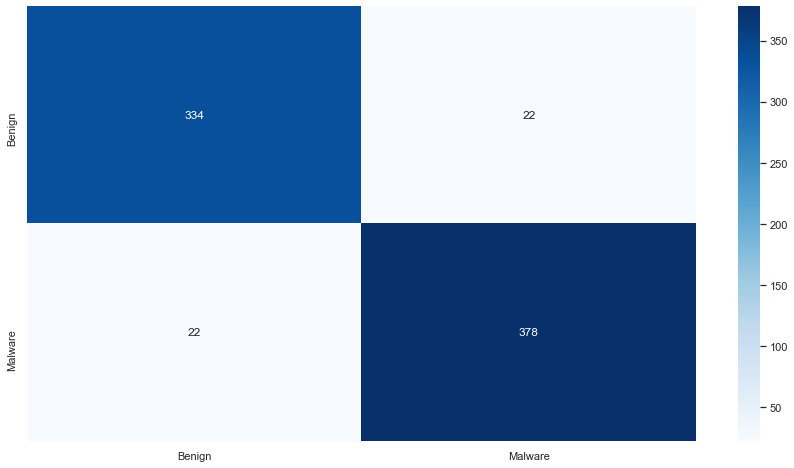

In [68]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = vot.predict(X_test)
true_labels = y_test
predictions_decoded = le.inverse_transform(predictions)
lc_matrix = confusion_matrix(true_labels, predictions_decoded)
lc_report = classification_report(true_labels, predictions_decoded, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

### soft voting

# Best classifier

In [69]:
vot_soft = VotingClassifier(estimators = [('Ada Boost', ada), ('Random forest', clf)], voting='soft')
# Encode labels
le = LabelEncoder()
le.fit(y_train)
y_encoded = le.transform(y_train)
vot_soft.fit(X_train, y_encoded)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1662), ('Malware', 1864)]


              precision    recall  f1-score   support

      Benign    0.93820   0.93820   0.93820       356
     Malware    0.94500   0.94500   0.94500       400

    accuracy                        0.94180       756
   macro avg    0.94160   0.94160   0.94160       756
weighted avg    0.94180   0.94180   0.94180       756



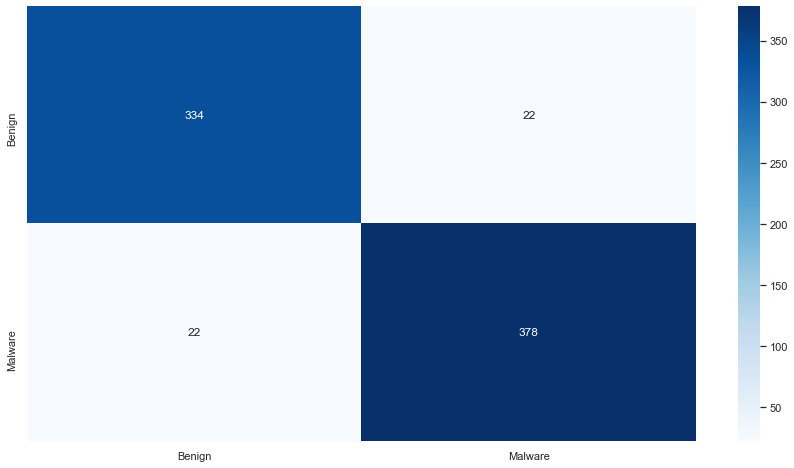

In [70]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = vot_soft.predict(X_test)
true_labels = y_test
predictions_decoded = le.inverse_transform(predictions)
lc_matrix = confusion_matrix(true_labels, predictions_decoded)
lc_report = classification_report(true_labels, predictions_decoded, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## Validation

In [263]:
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,request.headers.Content-Length,response.headers.Location,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=dVlNEpf8NxpyzA7muTOQZq27dstyz3vLvC3KTFuL7...,"Mon, 21 Nov 2022 18:39:55 GMT",GET,http://127.0.0.1:5000/orders/check/exists/9701,,404 NOT FOUND,text/html; charset=utf-8,207,404,<!doctype html>\n<html lang=en>\n<title>404 No...,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=PY7dmka20pTIpRcGuLe1VPC17-BM9dFTDxFDvBiyB...,"Mon, 21 Nov 2022 18:39:56 GMT",GET,http://127.0.0.1:5000/categories/check/number/...,,404 NOT FOUND,application/json,43,404,"{""error"": ""Category number not found""}",NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=P2xUfJ_H_sPMvdBExjCc4-IpiOVF2gC3D9FfvZSLY...,"Mon, 21 Nov 2022 18:39:57 GMT",GET,http://127.0.0.1:5000/states/6885,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=vVS_oJohZvCG9m9gekak9nJThQlQMi1yKVQMPUP-P...,"Mon, 21 Nov 2022 18:39:57 GMT",GET,http://127.0.0.1:5000/states/10070,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:27...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=q0CwX5jOFhPJhae8pwXSjGuVec609HBBwppoXrjXG...,"Mon, 21 Nov 2022 18:39:58 GMT",GET,http://127.0.0.1:5000/about/greet,,200 OK,text/html; charset=utf-8,664,200,<p>If you get stuck or just want to check your...,NaN,NaN,NaN,NaN


In [264]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,request.headers.Content-Length,response.headers.Location,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=dVlNEpf8NxpyzA7muTOQZq27dstyz3vLvC3KTFuL7...,"Mon, 21 Nov 2022 18:39:55 GMT",GET,http://127.0.0.1:5000/orders/check/exists/9701,,404 NOT FOUND,text/html; charset=utf-8,207,404,<!doctype html>\n<html lang=en>\n<title>404 No...,None,None,None,None
1,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=PY7dmka20pTIpRcGuLe1VPC17-BM9dFTDxFDvBiyB...,"Mon, 21 Nov 2022 18:39:56 GMT",GET,http://127.0.0.1:5000/categories/check/number/...,,404 NOT FOUND,application/json,43,404,"{""error"": ""Category number not found""}",None,None,None,None
2,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=P2xUfJ_H_sPMvdBExjCc4-IpiOVF2gC3D9FfvZSLY...,"Mon, 21 Nov 2022 18:39:57 GMT",GET,http://127.0.0.1:5000/states/6885,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",None,None,None,None
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=vVS_oJohZvCG9m9gekak9nJThQlQMi1yKVQMPUP-P...,"Mon, 21 Nov 2022 18:39:57 GMT",GET,http://127.0.0.1:5000/states/10070,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",None,None,None,None
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:27...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=q0CwX5jOFhPJhae8pwXSjGuVec609HBBwppoXrjXG...,"Mon, 21 Nov 2022 18:39:58 GMT",GET,http://127.0.0.1:5000/about/greet,,200 OK,text/html; charset=utf-8,664,200,<p>If you get stuck or just want to check your...,None,None,None,None


In [265]:
df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.status_code,response.body,request.headers.Cookie,request.headers.Content-Length,response.headers.Location,response.headers.Set-Cookie
0,0,0.894427,0,0,0,0,0,0,0,0,0.000000,0,0.577350,4,-0.408248,404,-0.801784,0.0,0.0,0.0,0.0
1,0,0.707107,0,0,0,0,0,0,0,0,0.529813,0,-0.577350,4,0.000000,404,0.554700,0.0,0.0,0.0,0.0
2,0,0.707107,0,0,0,1,0,1,0,0,0.341882,0,-0.577350,4,0.000000,404,0.707107,0.0,0.0,0.0,0.0
3,0,0.000000,0,0,0,3,0,0,0,0,0.639602,0,-0.447214,4,0.000000,404,0.707107,0.0,0.0,0.0,0.0
4,0,0.000000,0,0,0,0,0,1,0,0,0.620174,0,0.000000,0,-0.408248,200,0.000000,0.0,0.0,0.0,0.0


In [221]:
df.drop('response.headers.Set-Cookie', axis=1, inplace=True)
df.drop('response.status_code', axis=1, inplace=True)
df.drop('request.headers.Host', axis=1, inplace=True)
df.drop('request.headers.Content-Length', axis=1, inplace=True)
df.drop('request.headers.User-Agent', axis=1, inplace=True)
df.drop('request.headers.Accept', axis=1, inplace=True)

df

,request.headers.Accept-Encoding,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.body,request.headers.Cookie,response.headers.Location
0,0,0,0,0,0,0,0,0.000000,0,0.577350,4,-0.408248,-0.801784,0.0,0.0
1,0,0,0,0,0,0,0,0.529813,0,-0.577350,4,0.000000,0.554700,0.0,0.0
2,0,0,1,0,1,0,0,0.341882,0,-0.577350,4,0.000000,0.707107,0.0,0.0
3,0,0,3,0,0,0,0,0.639602,0,-0.447214,4,0.000000,0.707107,0.0,0.0
4,0,0,0,0,1,0,0,0.620174,0,0.000000,0,-0.408248,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0,0,2,0,0,0,0,-0.111111,0,-0.408248,0,0.000000,-0.872872,0.0,0.0
751,0,0,3,0,0,0,0,-0.140028,0,0.707107,0,-0.408248,-0.447214,0.0,0.0
752,0,0,0,0,1,0,0,0.000000,0,0.000000,0,-0.408248,0.929981,0.0,0.0
753,0,0,0,0,0,0,0,0.182574,0,0.707107,0,-0.408248,-0.577350,0.0,0.0


In [222]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   request.headers.Accept-Encoding  755 non-null    int32  
 1   request.headers.Connection       755 non-null    int32  
 2   request.headers.Accept-Language  755 non-null    int32  
 3   request.headers.Sec-Fetch-Site   755 non-null    int32  
 4   request.headers.Sec-Fetch-Mode   755 non-null    int32  
 5   request.headers.Sec-Fetch-User   755 non-null    int32  
 6   request.headers.Sec-Fetch-Dest   755 non-null    int32  
 7   request.headers.Set-Cookie       755 non-null    float64
 8   request.method                   755 non-null    int32  
 9   request.url                      755 non-null    float64
 10  response.status                  755 non-null    int32  
 11  response.headers.Content-Type    755 non-null    float64
 12  response.body         

In [223]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

In [266]:
val = df[features_list].to_numpy()

sns.set(rc={'figure.figsize':(15,8)})
prediction = cat.predict(val)
predictions_decoded = le.inverse_transform(prediction)
print(predictions_decoded)

KeyError: "['tag_num'] not in index"

In [168]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions_decoded), fmt='%2d')